Objective:
Build a model to predict a price range of cars based on the features contained in the file data.csv

We will be looking at the following points:
- EDA: try to create only plots that you think might be potentially useful for understanding the data or building the model later on
- Data cleaning/processing
- Build the model
- Model evaluation
- Clarity of your output and comments

Try commenting on the model performance, feature importance and potential future improvements
If you have time, feel free to improve the model performance with any techniques you would like (including for example another type of model). Finally, try commenting on how you would put this model into production. Feel free to explain as many points as you would like.

You can use Python or R.
When producing your output, consider as you will present it to a client who is business oriented but not technically advanced. Therefore, comment and explain clearly what you do.

* Make: car maker
* Model: car model
* Year: year the car was manufactured
* Engine Fuel Type: engine fuel type
* Engine HP: engine horse power
* Engine Cylinders: engine cylinders
* Transmission type: transmission type
* Driven_Wheels: driven wheels
* Number of Doors: number of doors of the car
* market category: category the car fits in
* vehicle size: vehicle size
* vehicle style: vehicle style
* highwas MPG: high way speed depending on the gallon of petrol or diesel in its tank
* city mpg: city speed
* popularity: popularity of the car
* MSRP: manufacturer suggested retail price


**Goal: predict the manufactuer suggested retail price**

## Import Libraries

In [407]:
import warnings 
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor, Pool

from statsmodels.stats.outliers_influence import variance_inflation_factor

import shap
import pickle

## Load Dataset

In [258]:
data = pd.read_csv('car_data.csv')

In [259]:
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [260]:
print(f"The Numbers of Rows and Columns in this data set are: {data.shape[0]} rows and {data.shape[1]} columns.")

The Numbers of Rows and Columns in this data set are: 11914 rows and 16 columns.


In [261]:
# change all column names into lowercase and replace space with underscores
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')

In [262]:
# lowercasing all the rows and replacing space with underscores
s = (data.dtypes == 'object')
obj_cols = list(s[s].index)

for col in obj_cols:
    data[col] = data[col].str.lower().str.replace(' ', '_')

In [263]:
data.sample(10)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
9780,chevrolet,sonic,2016,regular_unleaded,138.0,4.0,automatic,front_wheel_drive,4.0,NaN,compact,sedan,35,24,1385,17545
11686,suzuki,xl-7,2006,regular_unleaded,185.0,6.0,automatic,rear_wheel_drive,4.0,NaN,midsize,4dr_suv,21,16,481,25499
11695,suzuki,xl7,2007,regular_unleaded,252.0,6.0,automatic,all_wheel_drive,4.0,crossover,midsize,4dr_suv,21,16,481,26999
10493,acura,tlx,2015,premium_unleaded_(recommended),290.0,6.0,automatic,all_wheel_drive,4.0,luxury,midsize,sedan,31,21,204,44800
7857,infiniti,q70,2015,premium_unleaded_(required),330.0,6.0,automatic,all_wheel_drive,4.0,"luxury,performance",large,sedan,24,17,190,52000
8514,kia,rio,2015,regular_unleaded,138.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,37,27,1720,17190
6313,buick,lacrosse,2017,regular_unleaded,310.0,6.0,automatic,all_wheel_drive,4.0,performance,large,sedan,29,20,155,43265
9302,gmc,sierra_1500_hybrid,2011,regular_unleaded,332.0,8.0,automatic,rear_wheel_drive,4.0,hybrid,large,crew_cab_pickup,23,20,549,45425
2741,chevrolet,cobalt,2008,regular_unleaded,173.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,32,22,1385,19695
3134,subaru,crosstrek,2017,regular_unleaded,148.0,4.0,automatic,all_wheel_drive,4.0,crossover,compact,4dr_suv,33,26,640,25195


## Exploratory Data Analysis

### Data type of columns

In [10]:
# Checking for data type of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_fuel_type   11911 non-null  object 
 4   engine_hp          11845 non-null  float64
 5   engine_cylinders   11884 non-null  float64
 6   transmission_type  11914 non-null  object 
 7   driven_wheels      11914 non-null  object 
 8   number_of_doors    11908 non-null  float64
 9   market_category    8172 non-null   object 
 10  vehicle_size       11914 non-null  object 
 11  vehicle_style      11914 non-null  object 
 12  highway_mpg        11914 non-null  int64  
 13  city_mpg           11914 non-null  int64  
 14  popularity         11914 non-null  int64  
 15  msrp               11914 non-null  int64  
dtypes: float64(3), int64(5

### Duplicate values

In [12]:
print(f'There are {data.duplicated().sum()} duplicate rows in the dataframe')

There are 715 duplicate rows in the dataframe


### Missing values

In [13]:
data.isna().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

For numerical variables engine_hp, this is continuous, we can fill it with **mean value**

But for engine_cylinders and number_of_doors, this values are distict values, using mean value will be weird, because we cannot have one and half doors or cylinders, so we can fill them with **mode**. 

### The number of unique values of the categorical features

In [14]:
for col in data[obj_cols]:
    unique_values = data[col].unique()
    print(col)
    #print(unique_values)
    print(f"The number of unique values are: {data[col].nunique()}")
    print('--------------------------')

make
The number of unique values are: 48
--------------------------
model
The number of unique values are: 914
--------------------------
engine_fuel_type
The number of unique values are: 10
--------------------------
transmission_type
The number of unique values are: 5
--------------------------
driven_wheels
The number of unique values are: 4
--------------------------
market_category
The number of unique values are: 71
--------------------------
vehicle_size
The number of unique values are: 3
--------------------------
vehicle_style
The number of unique values are: 16
--------------------------


make, model, engine_fuel_type, transmission_type, driven_wheels, market_category and vehicle_style are nominal variables, so we can use one-hot encoding. 

vehicle_size is ordinal: 'compact', 'Midsize', 'Large', but we don't know how much larger large is than mid-size, the spacing between these values is arbiturary, it is sort of ambiguous, so we still use one-hot encoding to skip the ambiguous nature. 

### Outliers

Interquartile range (IQR = Q3 - Q1) detect outliers and is used on skewed data distribution. Data points that falls below Q1-1.5 IQR (where Q1 is 25) and above Q3+1.5 IQR (where Q1 is 75) are categorised as outliers.

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,11914.0,2010.384338,7.579740,1990.0,2007.0,2015.0,2016.00,2017.0
engine_hp,11845.0,249.386070,109.191870,55.0,170.0,227.0,300.00,1001.0
engine_cylinders,11884.0,5.628829,1.780559,0.0,4.0,6.0,6.00,16.0
number_of_doors,11908.0,3.436093,0.881315,2.0,2.0,4.0,4.00,4.0
highway_mpg,11914.0,26.637485,8.863001,12.0,22.0,26.0,30.00,354.0
city_mpg,11914.0,19.733255,8.987798,7.0,16.0,18.0,22.00,137.0
popularity,11914.0,1554.911197,1441.855347,2.0,549.0,1385.0,2009.00,5657.0
msrp,11914.0,40594.737032,60109.103604,2000.0,21000.0,29995.0,42231.25,2065902.0


Comparing the mean of each column with the min/max value, **engine_hp**, **highway_mpg**, **city_mpg**, **popularity** and msrp might have outliers, because there is a considerable difference between average value and max value

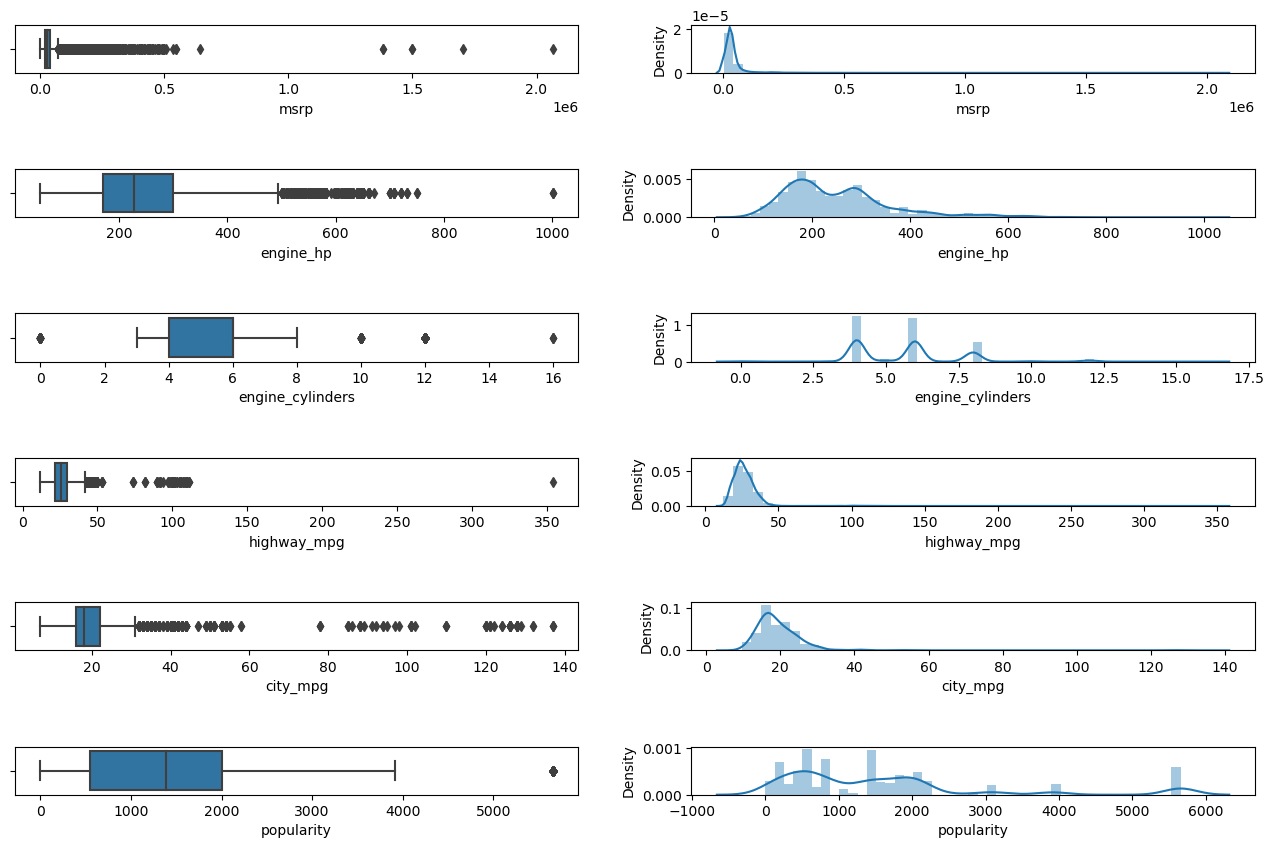

In [16]:
# Plot box plot to detect outliers of dependend variable msrp
plt.figure(figsize=(16, 10))
plt.subplot(6, 2, 1)
sns.boxplot(x='msrp', data=data)
plt.subplot(6, 2, 2)
sns.distplot(data['msrp'])

# engine hp
plt.subplot(6, 2, 3)
sns.boxplot(x='engine_hp', data=data)
plt.subplot(6, 2, 4)
sns.distplot(data['engine_hp'])

# engine cylinders
plt.subplot(6, 2, 5)
sns.boxplot(x='engine_cylinders', data=data)
plt.subplot(6, 2, 6)
sns.distplot(data['engine_cylinders'])

# highway_mpg
plt.subplot(6, 2, 7)
sns.boxplot(x='highway_mpg', data=data)
plt.subplot(6, 2, 8)
sns.distplot(data['highway_mpg'])

# city_mpg
plt.subplot(6, 2, 9)
sns.boxplot(x='city_mpg', data=data)
plt.subplot(6, 2, 10)
sns.distplot(data['city_mpg'])

# popularity
plt.subplot(6, 2, 11)
sns.boxplot(x='popularity', data=data)
plt.subplot(6, 2, 12)
sns.distplot(data['popularity'])


plt.subplots_adjust(hspace=2)

### Check the distribution of dependent variable

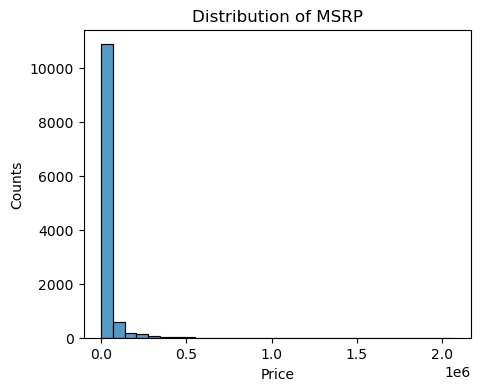

In [36]:
plt.figure(figsize=(5,4))
sns.histplot(data['msrp'], bins=30)
plt.title("Distribution of MSRP")
plt.ylabel("Counts")
plt.xlabel("Price")
plt.show()

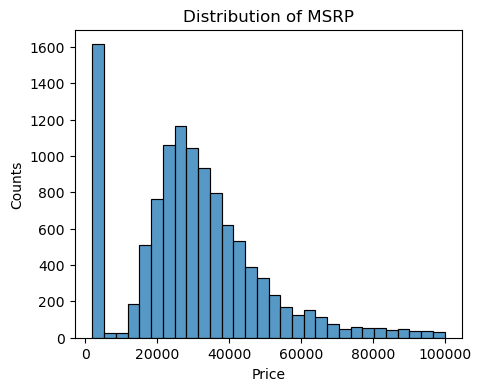

In [39]:
plt.figure(figsize=(5,4))
sns.histplot(data['msrp'][data['msrp'] < 100000], bins=30)
plt.title("Distribution of MSRP")
plt.ylabel("Counts")
plt.xlabel("Price")
plt.show()

The distribution of MSRP is right skewed and has a long tail, removing outliers using IQR will definitely wipe out the cars over 100000, maybe consider log transformation

### Checking the correlation matrix

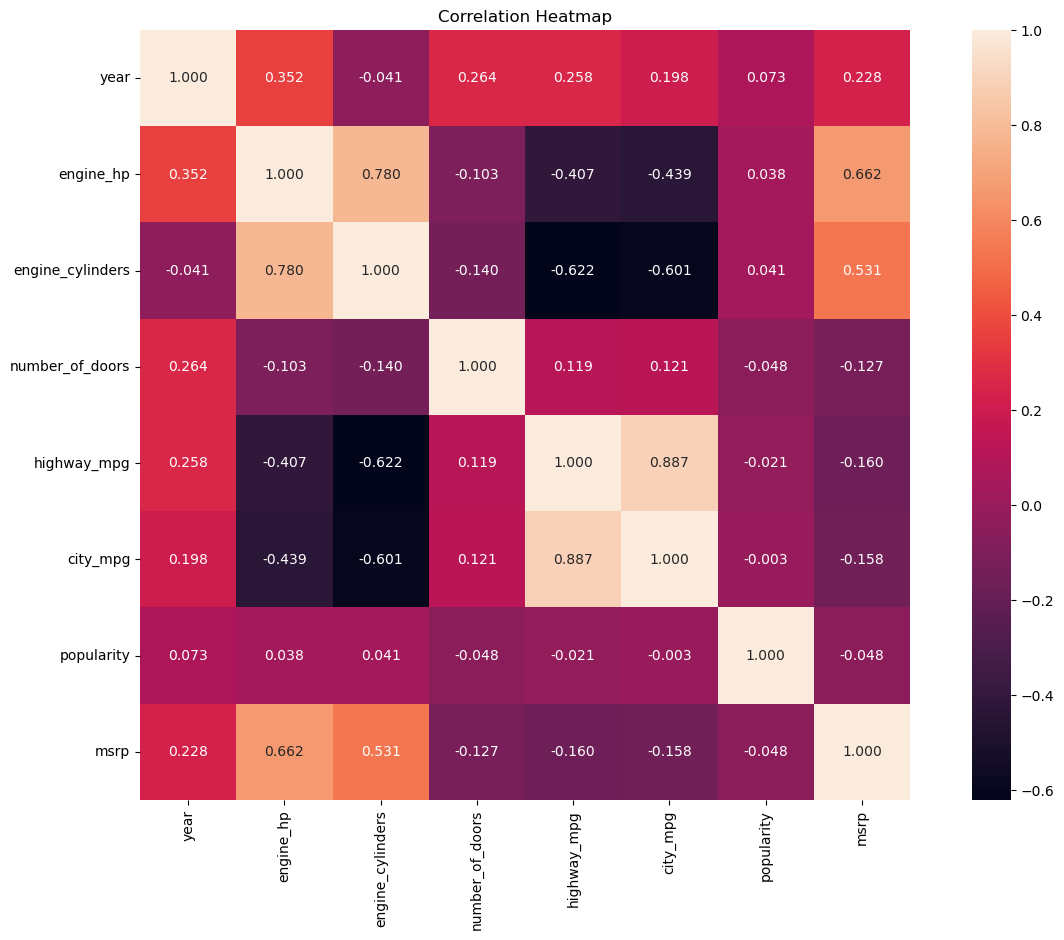

In [18]:
corr = data.corr()

plt.figure(figsize=(16, 10))
ax = sns.heatmap(corr, annot=True, square=True, fmt='.3f', linecolor='black')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Correlation Heatmap')
plt.show()

In [26]:
corr['msrp'].sort_values(ascending=False)

msrp                1.000000
engine_hp           0.662008
engine_cylinders    0.531312
year                0.227590
popularity         -0.048476
number_of_doors    -0.126635
city_mpg           -0.157676
highway_mpg        -0.160043
Name: msrp, dtype: float64

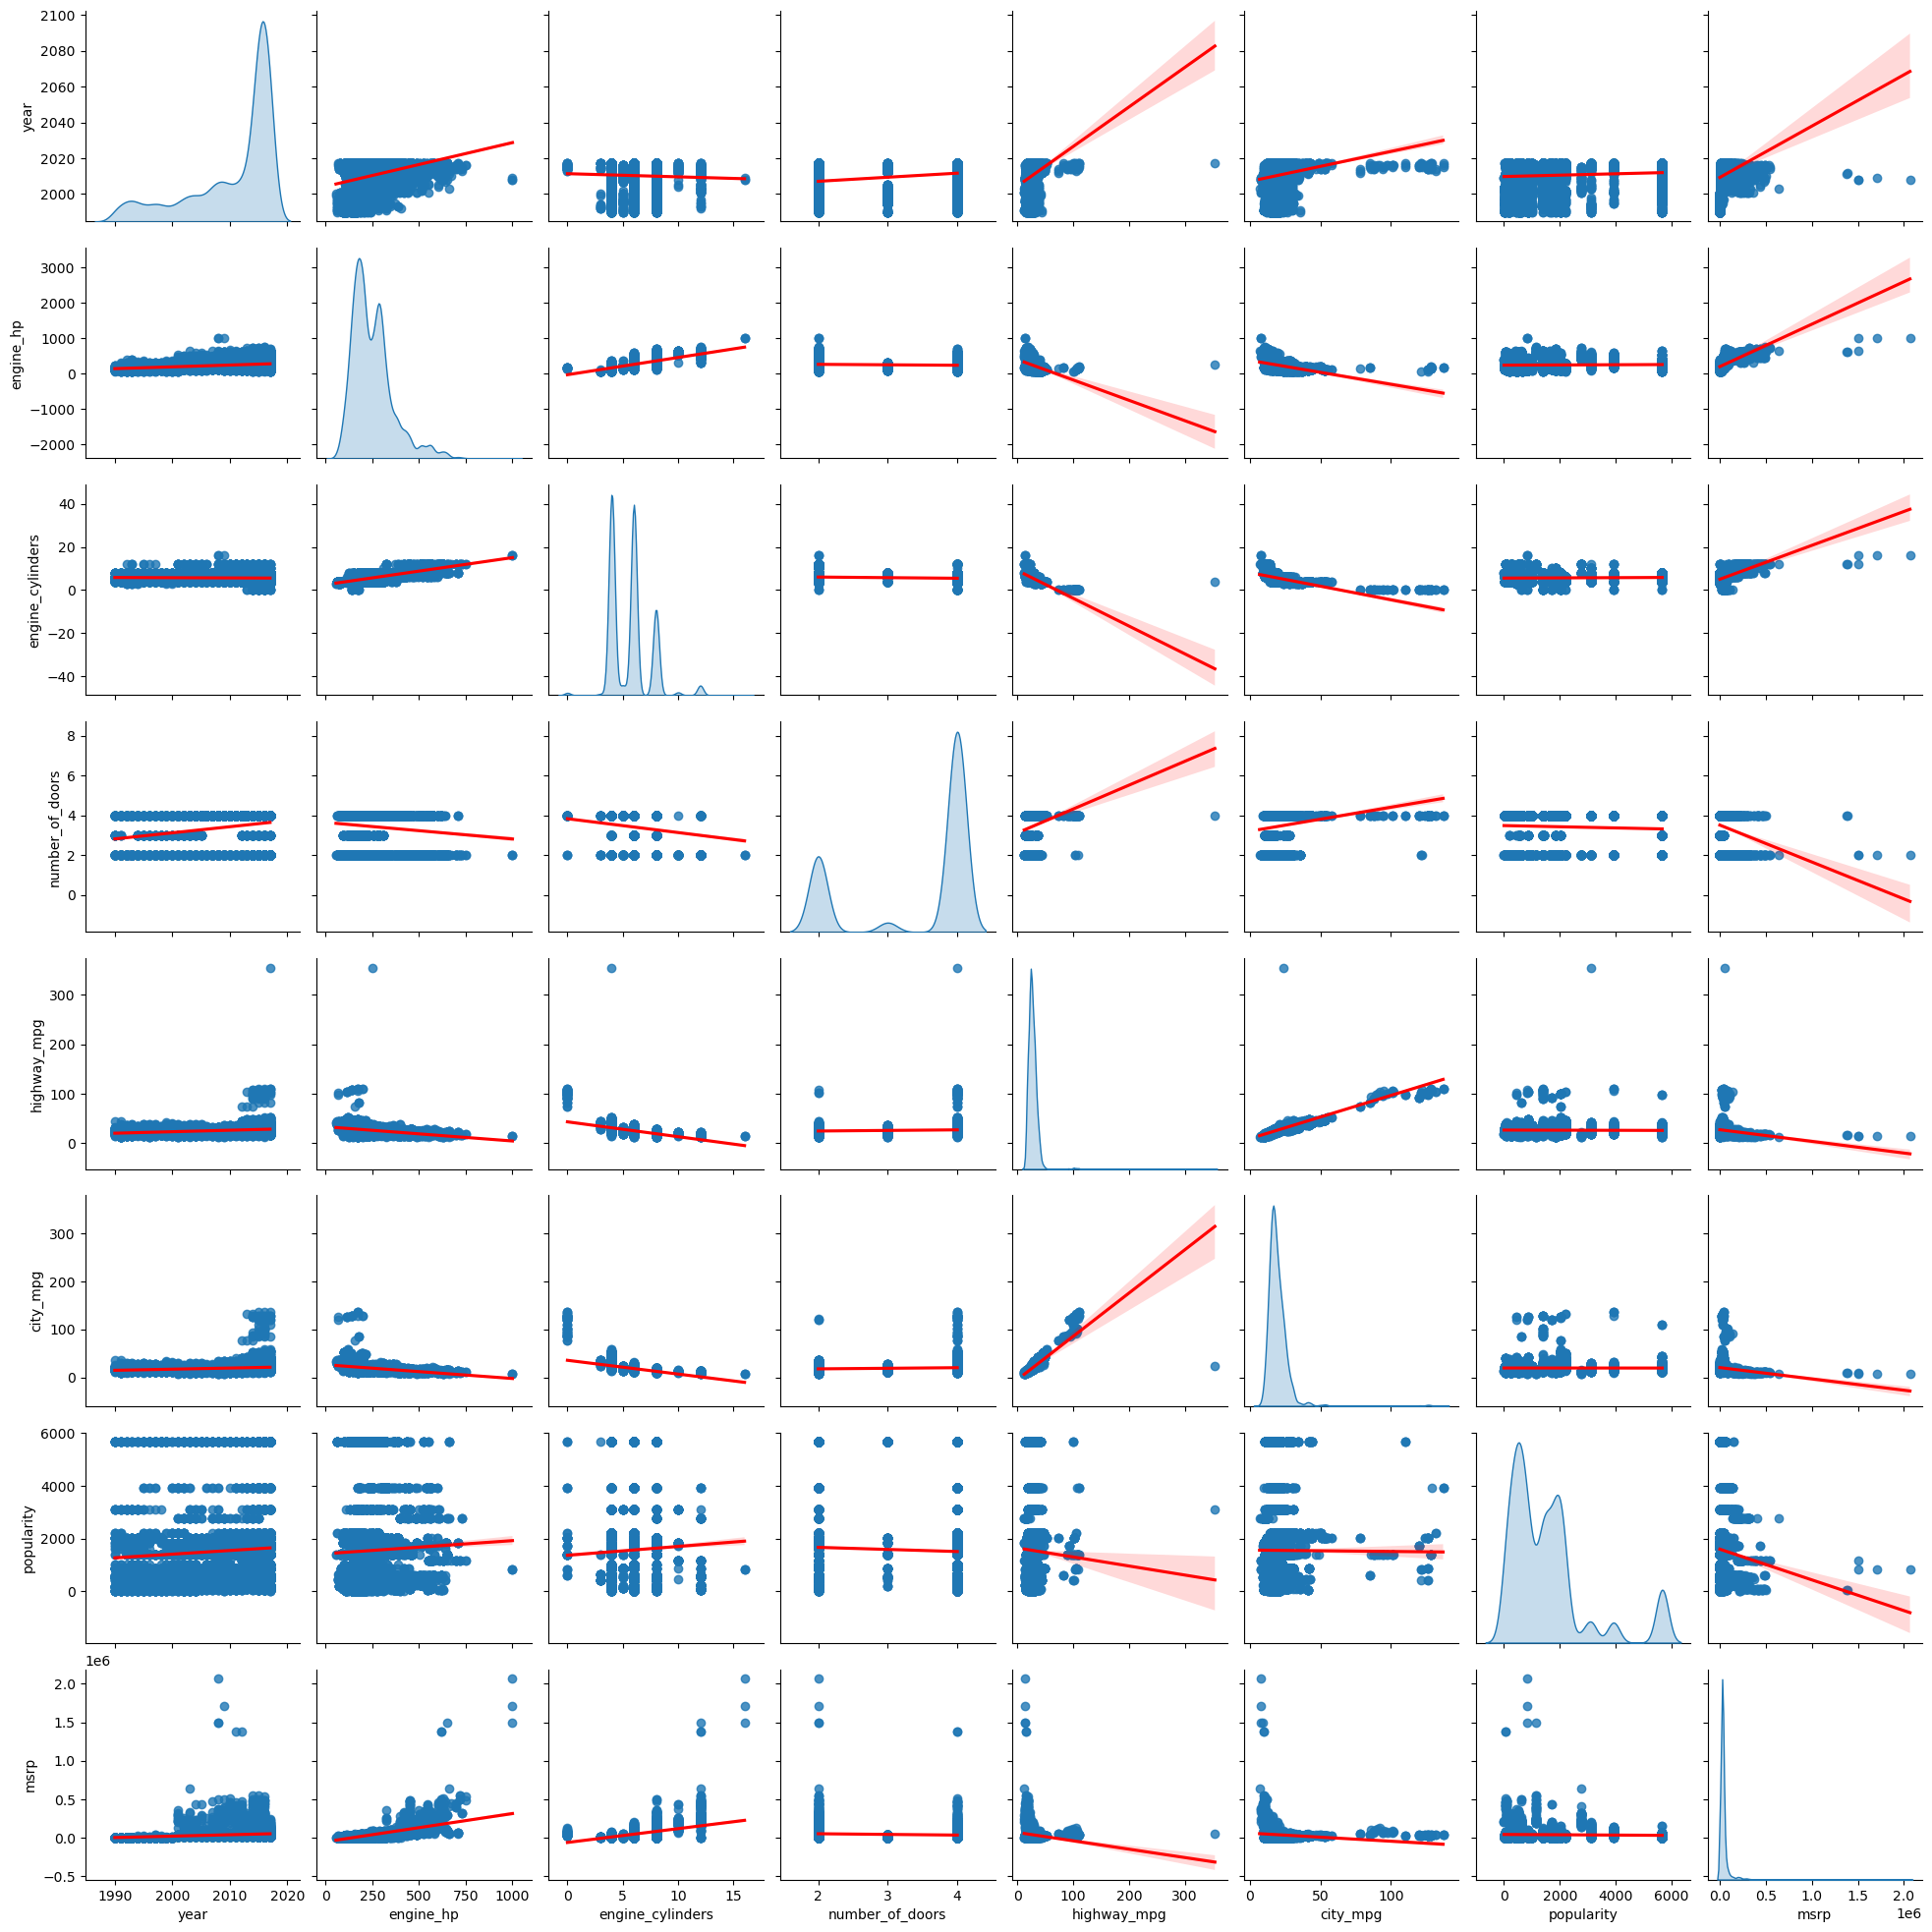

In [29]:
sns.pairplot(data, kind='reg', diag_kind='kde', plot_kws={'line_kws': {'color':'red'}})

High correlation between
- Engine cylinders & Engine HP
- high way mpg & city mpg

The more cylinders there are, the more powerful the car is

High anticorrelation
- Engine cylinders & highway mpg

Highway mpg / Engine Cylinders have a strong negative correlation with highway and city MPG because lower MPG figures mean higher fuel consumption.


### Feature influence on price

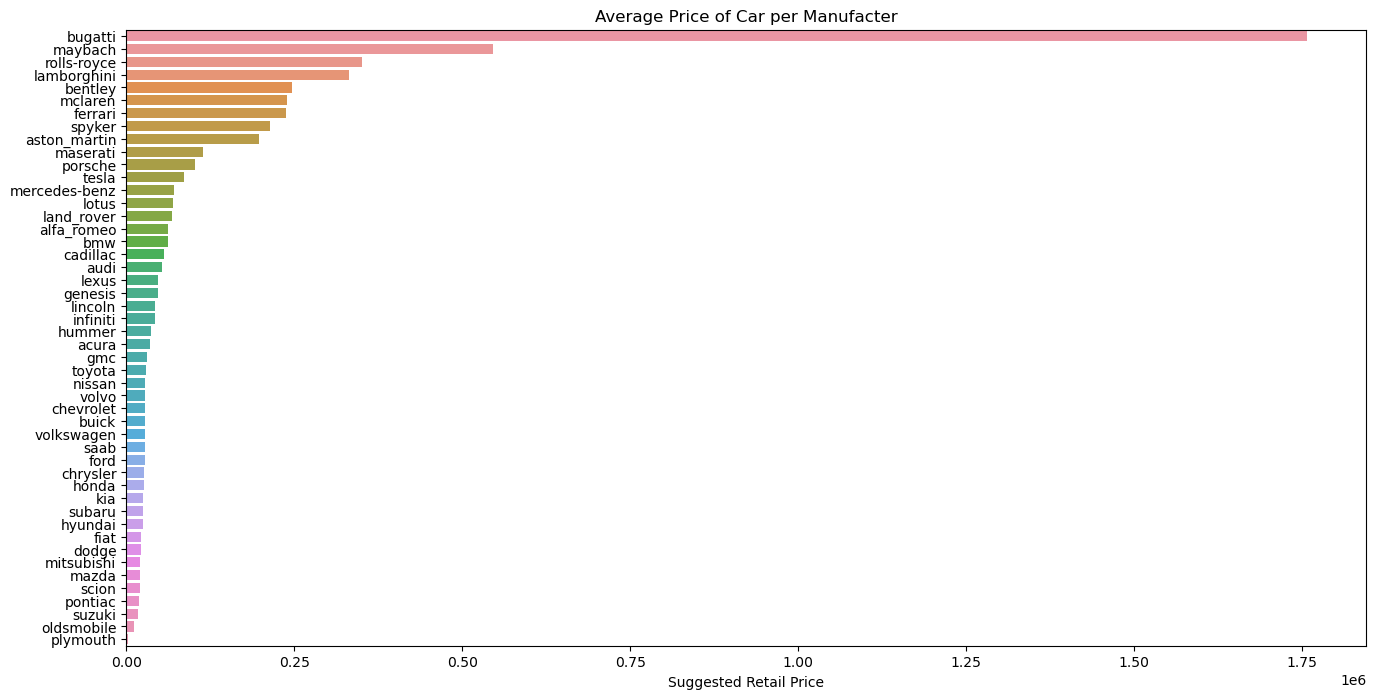

In [33]:
brand = data.groupby('make')['msrp'].mean().reset_index()
brand.sort_values(by='msrp', ascending=False, inplace=True)

plt.figure(figsize=(16,8))
sns.barplot(data=brand, y='make', x='msrp')
plt.ylabel(None)
plt.xlabel('Suggested Retail Price')
plt.title("Average Price of Car per Manufacter")
plt.show()

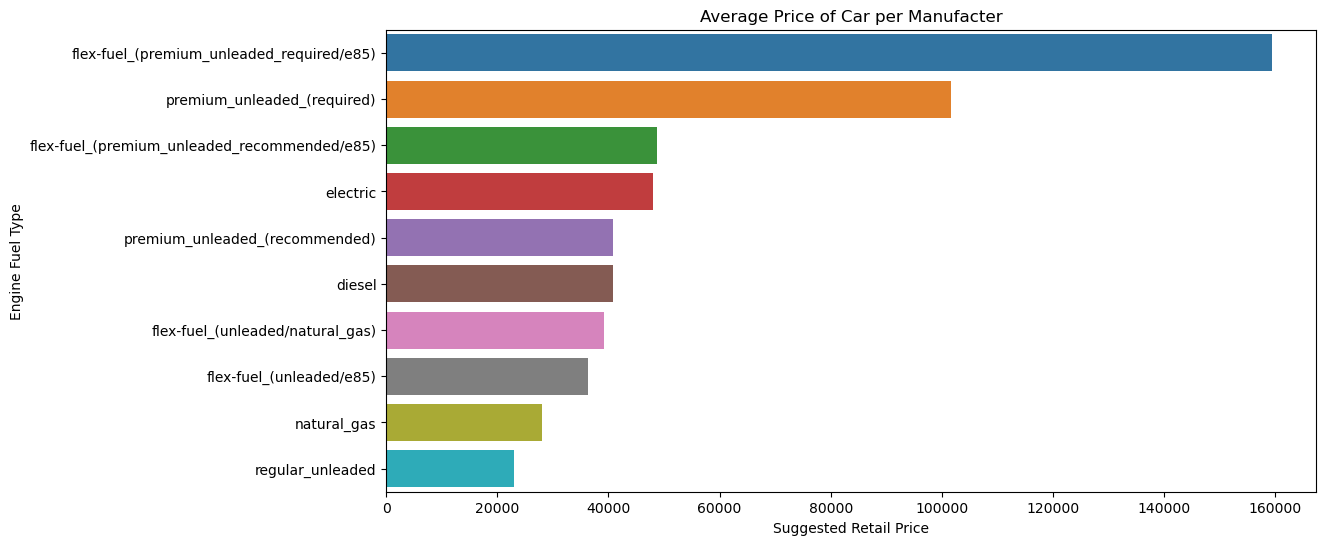

In [51]:
fuel_prices = data.groupby('engine_fuel_type')['msrp'].mean().reset_index()

fuel_prices.sort_values(by='msrp', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=fuel_prices, y='engine_fuel_type', x='msrp')
plt.ylabel('Engine Fuel Type')
plt.xlabel('Suggested Retail Price')
plt.title("Average Price of Car per Manufacter")
plt.show()

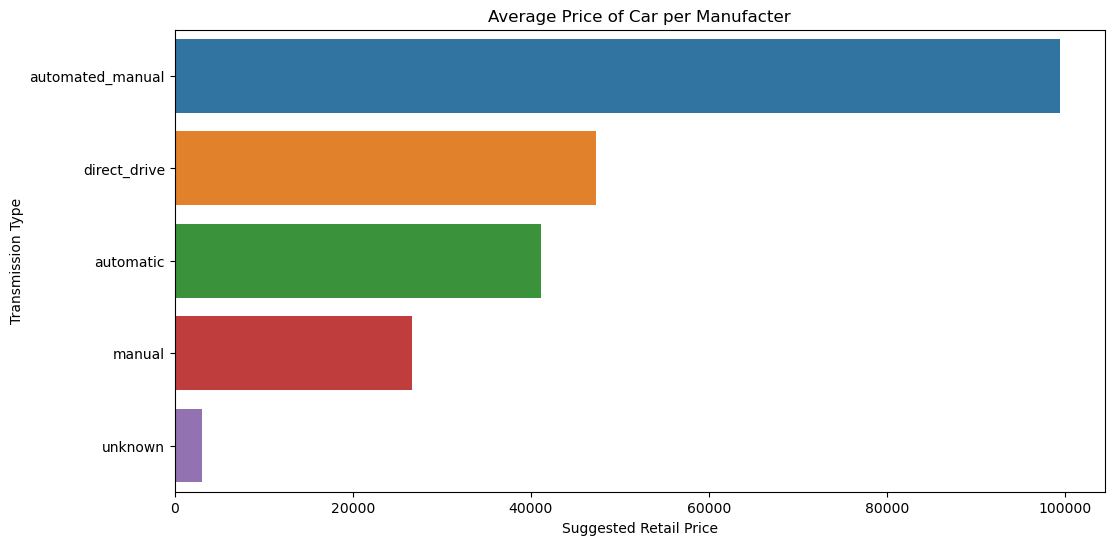

In [52]:
transmission_prices = data.groupby('transmission_type')['msrp'].mean().reset_index()

transmission_prices.sort_values(by='msrp', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=transmission_prices, y='transmission_type', x='msrp')
plt.ylabel('Transmission Type')
plt.xlabel('Suggested Retail Price')
plt.title("Average Price of Car per Manufacter")
plt.show()

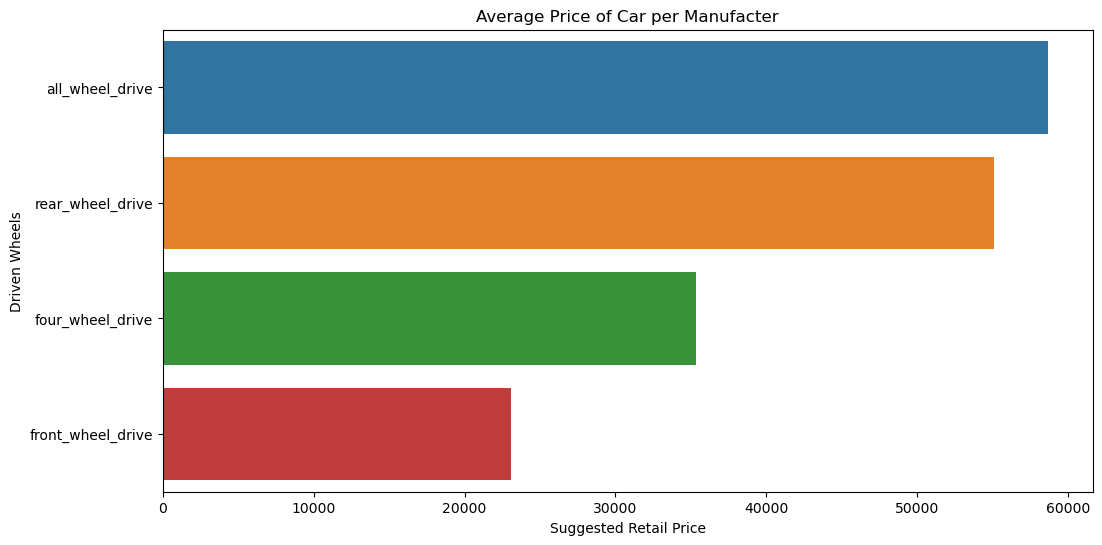

In [53]:
wheels_prices = data.groupby('driven_wheels')['msrp'].mean().reset_index()

wheels_prices.sort_values(by='msrp', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=wheels_prices, y='driven_wheels', x='msrp')
plt.ylabel('Driven Wheels')
plt.xlabel('Suggested Retail Price')
plt.title("Average Price of Car per Manufacter")
plt.show()

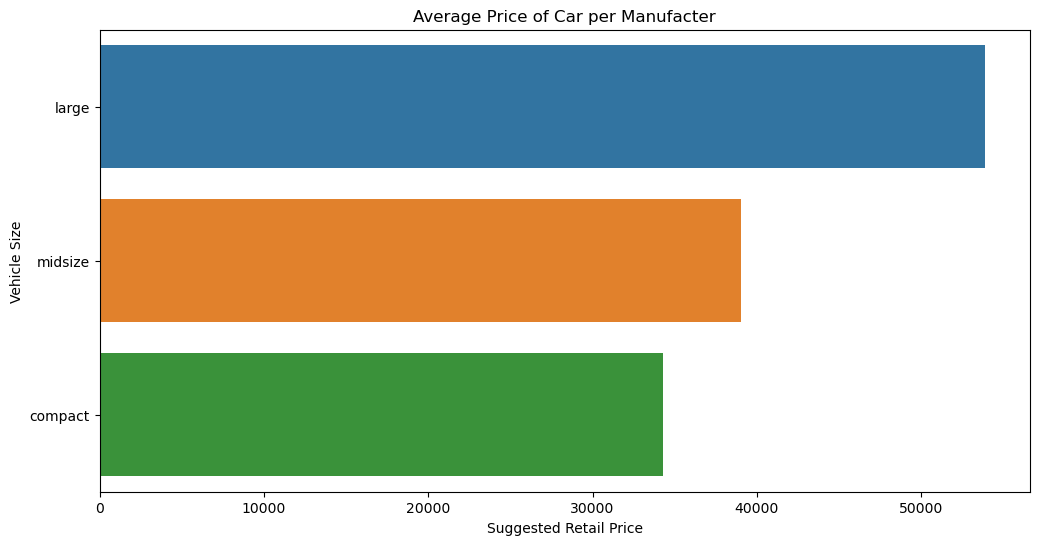

In [54]:
vehicle_size_prices = data.groupby('vehicle_size')['msrp'].mean().reset_index()

vehicle_size_prices.sort_values(by='msrp', ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(data=vehicle_size_prices, y='vehicle_size', x='msrp')
plt.ylabel('Vehicle Size')
plt.xlabel('Suggested Retail Price')
plt.title("Average Price of Car per Manufacter")
plt.show()

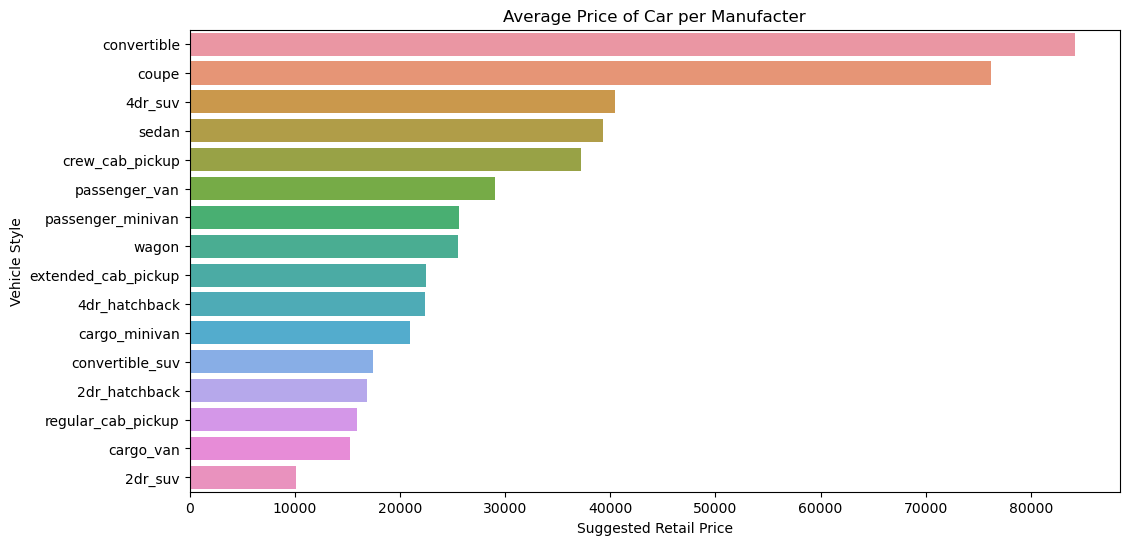

In [55]:
vehicle_style_prices = data.groupby('vehicle_style')['msrp'].mean().reset_index()

vehicle_style_prices.sort_values(by='msrp', ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(data=vehicle_style_prices, y='vehicle_style', x='msrp')
plt.ylabel('Vehicle Style')
plt.xlabel('Suggested Retail Price')
plt.title("Average Price of Car per Manufacter")
plt.show()

## Data Cleaning and Preprocessing

### Handling duplicates

In [293]:
df = data.copy()

# Drop duplicates
df = df.drop_duplicates(keep='first')

df.duplicated().sum()

0

### Handling missing values

In [294]:
# Fill missing values in market category column, replace them with missing
df['market_category'] = df['market_category'].fillna('missing')
df['market_category'] = df['market_category'].apply(lambda x: x.split(','))

# Later we will use onehot encoder to encode the categorical values, onehot encoder can handle missing values for categorical data

# Fill missing values in the numerical columns engine_hp and engine_cylinders
# for engine_hp use mean value, because the value is continuous
# for number_of_doors, and engine_cylinders we use mode, because the value should be an integer
df['engine_hp'] = df['engine_hp'].fillna(df['engine_hp'].mean())
for column in ['engine_cylinders', 'number_of_doors']:
    df[column] = df[column].fillna(df[column].mode()[0])

In [295]:
df.isna().sum()

make                 0
model                0
year                 0
engine_fuel_type     3
engine_hp            0
engine_cylinders     0
transmission_type    0
driven_wheels        0
number_of_doors      0
market_category      0
vehicle_size         0
vehicle_style        0
highway_mpg          0
city_mpg             0
popularity           0
msrp                 0
dtype: int64

In [296]:
df = df.dropna()

In [297]:
df.isna().sum()

make                 0
model                0
year                 0
engine_fuel_type     0
engine_hp            0
engine_cylinders     0
transmission_type    0
driven_wheels        0
number_of_doors      0
market_category      0
vehicle_size         0
vehicle_style        0
highway_mpg          0
city_mpg             0
popularity           0
msrp                 0
dtype: int64

### Split data set

In [344]:
# Split df into X and y

# use log(1+x) transformation to reduce the influence of outliers, +1 is important in case of zero values
#y = np.log1p(df['msrp'])
y = df['msrp']
X = df.drop('msrp', axis=1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

print(f'Training data size: {X_train.shape[0]}')
print(f'Test data size: {X_test.shape[0]}')

Training data size: 8956
Test data size: 2240


In [345]:
X_train.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
5061,infiniti,fx,2012,premium_unleaded_(required),303.0,6.0,automatic,rear_wheel_drive,4.0,"[crossover, luxury]",midsize,4dr_suv,23,16,190
4586,ford,f-150,2017,regular_unleaded,325.0,6.0,automatic,rear_wheel_drive,4.0,[flex_fuel],large,crew_cab_pickup,26,19,5657
495,toyota,4runner,2015,regular_unleaded,270.0,6.0,automatic,four_wheel_drive,4.0,[missing],midsize,4dr_suv,21,17,2031
2921,rolls-royce,corniche,2001,premium_unleaded_(required),325.0,8.0,automatic,rear_wheel_drive,2.0,"[exotic, luxury]",large,convertible,15,10,86
8472,suzuki,reno,2006,regular_unleaded,126.0,4.0,automatic,front_wheel_drive,4.0,[hatchback],compact,4dr_hatchback,28,19,481


In [346]:
X_test

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
7163,lincoln,navigator,2017,regular_unleaded,380.0,6.0,automatic,four_wheel_drive,4.0,[luxury],large,4dr_suv,19,15,61
3267,cadillac,cts,2016,regular_unleaded,335.0,6.0,automatic,rear_wheel_drive,4.0,"[luxury, high-performance]",large,sedan,30,20,1624
6585,infiniti,m30,1991,regular_unleaded,162.0,6.0,automatic,rear_wheel_drive,2.0,[luxury],midsize,coupe,23,17,190
11576,volvo,xc60,2015,regular_unleaded,250.0,5.0,automatic,all_wheel_drive,4.0,"[crossover, luxury]",midsize,4dr_suv,25,18,870
8608,volkswagen,routan,2010,regular_unleaded,251.0,6.0,automatic,front_wheel_drive,4.0,[missing],midsize,passenger_minivan,25,17,873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180,cadillac,ct6,2016,regular_unleaded,335.0,6.0,automatic,all_wheel_drive,4.0,"[luxury, performance]",large,sedan,27,18,1624
11693,suzuki,xl7,2007,regular_unleaded,252.0,6.0,automatic,all_wheel_drive,4.0,[crossover],midsize,4dr_suv,21,16,481
466,ferrari,458_italia,2013,premium_unleaded_(required),562.0,8.0,automated_manual,rear_wheel_drive,2.0,"[exotic, high-performance]",compact,convertible,17,13,2774
8121,dodge,ram_50_pickup,1992,regular_unleaded,115.0,4.0,manual,rear_wheel_drive,2.0,[missing],compact,regular_cab_pickup,22,17,1851


### Encode categorical features

In [347]:
# Use MultilabelBinarizer to encode market_category
mlb = MultiLabelBinarizer()

mlb.fit(X_train['market_category'])
mlb_cols_train = pd.DataFrame(mlb.transform(X_train['market_category']), columns=mlb.classes_)
mlb_cols_test = pd.DataFrame(mlb.transform(X_test['market_category']), columns=mlb.classes_)

mlb_cols_train.index = X_train.index
mlb_cols_test.index = X_test.index

mlb_X_train = X_train.drop(columns=['market_category'], axis=1)
mlb_X_test = X_test.drop(columns=['market_category'], axis=1)


mlb_X_train = pd.concat([mlb_X_train, mlb_cols_train], axis=1)
mlb_X_test = pd.concat([mlb_X_test, mlb_cols_test], axis=1)

In [274]:
obj_cols.remove('market_category')

In [348]:
# Use One-Hot encoder to encode the remaining categorical features
# One-hot encoding categorical features

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_encoder.fit(mlb_X_train[obj_cols])
OH_cols_train = pd.DataFrame(OH_encoder.transform(mlb_X_train[obj_cols]), columns=OH_encoder.get_feature_names_out())
OH_cols_test = pd.DataFrame(OH_encoder.transform(mlb_X_test[obj_cols]), columns=OH_encoder.get_feature_names_out())

# One-hot encoding removed index; put it back
OH_cols_train.index = mlb_X_train.index
OH_cols_test.index = mlb_X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = mlb_X_train.drop(obj_cols, axis=1)
num_X_test = mlb_X_test.drop(obj_cols, axis=1)


# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

In [349]:
print(f'Train dataset size after encoding: {OH_X_train.shape}')
print(f'Test dataset size after encoding: {OH_X_test.shape}')

Train dataset size after encoding: (8956, 1005)
Test dataset size after encoding: (2240, 1005)


In [350]:
OH_X_train

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,crossover,diesel,exotic,...,vehicle_style_convertible,vehicle_style_convertible_suv,vehicle_style_coupe,vehicle_style_crew_cab_pickup,vehicle_style_extended_cab_pickup,vehicle_style_passenger_minivan,vehicle_style_passenger_van,vehicle_style_regular_cab_pickup,vehicle_style_sedan,vehicle_style_wagon
5061,2012,303.0,6.0,4.0,23,16,190,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4586,2017,325.0,6.0,4.0,26,19,5657,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
495,2015,270.0,6.0,4.0,21,17,2031,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2921,2001,325.0,8.0,2.0,15,10,86,0,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8472,2006,126.0,4.0,4.0,28,19,481,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6053,2012,170.0,5.0,4.0,31,24,873,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5440,2017,170.0,4.0,4.0,34,25,873,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5664,2013,200.0,4.0,2.0,31,21,873,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,1996,185.0,4.0,4.0,23,15,376,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature scaling

In [351]:
cols_scale = ['year', 'engine_hp', 'engine_cylinders', 'number_of_doors', 'highway_mpg', 'city_mpg', 'popularity']

In [352]:
scaler = StandardScaler()

OH_X_train[cols_scale] = scaler.fit_transform(OH_X_train[cols_scale])
OH_X_test[cols_scale] = scaler.transform(OH_X_test[cols_scale])

### Dimensionality reduction

In [353]:
# 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(OH_X_train)

OH_X_train_reduced = pd.DataFrame(pca.transform(OH_X_train), index=OH_X_train.index)
OH_X_test_reduced = pd.DataFrame(pca.transform(OH_X_test), index=OH_X_test.index)

In [354]:
print(f'Train data before PCA size: {OH_X_train.shape}')
print(f'Train data after PCA size: {OH_X_train_reduced.shape}')
print(f'Test data before PCA size: {OH_X_test.shape}')
print(f'Train data after PCA size: {OH_X_test_reduced.shape}')

Train data before PCA size: (8956, 1005)
Train data after PCA size: (8956, 137)
Test data before PCA size: (2240, 1005)
Train data after PCA size: (2240, 137)


## Modeling (Baseline model using linear regression)

In [355]:
lin_reg = LinearRegression()
lin_reg.fit(OH_X_train_reduced, y_train)

lin_y_pred = lin_reg.predict(OH_X_test_reduced)

#Evaluation
lin_reg_cv_scores = cross_val_score(lin_reg, OH_X_train_reduced, y_train, scoring='neg_mean_squared_error', cv=10)
lin_reg_rmse_scores = np.sqrt(-lin_reg_cv_scores)

lin_mae = mean_absolute_error(y_test, lin_y_pred)
lin_mse = mean_squared_error(y_test, lin_y_pred)
lin_rmse = np.sqrt(lin_mse)


print(f'Linear Regression Mean absolute error on training: {mean_absolute_error(y_train, lin_reg.predict(OH_X_train_reduced)):.2f}')
print(f'Linear Regression Mean squared error on training: {mean_squared_error(y_train, lin_reg.predict(OH_X_train_reduced)):.2f}')
print(f'Linear Regression Root mean squared error on training: {np.sqrt(mean_squared_error(y_train, lin_reg.predict(OH_X_train_reduced))):.2f}')
print('---------------------------')
print(f"Linear Regression Root Mean squared CV Scores: {lin_reg_rmse_scores.mean():.2f}")
print(f'Linear Regression Mean absolute error: {lin_mae:.2f}')
print(f'Linear Regression Mean squared error: {lin_mse:.2f}')
print(f'Linear Regression Root mean squared error: {lin_rmse:.2f}')

print(f'Linear Regression R-squred score on train data: {lin_reg.score(OH_X_train_reduced, y_train)}')
print(f'Linear Regression R-squred score on test data: {lin_reg.score(OH_X_test_reduced, y_test)}')

Linear Regression Mean absolute error on training: 13275.65
Linear Regression Mean squared error on training: 1301104268.48
Linear Regression Root mean squared error on training: 36070.82
---------------------------
Linear Regression Root Mean squared CV Scores: 34280.56
Linear Regression Mean absolute error: 13396.90
Linear Regression Mean squared error: 938600554.85
Linear Regression Root mean squared error: 30636.59
Linear Regression R-squred score on train data: 0.674685661767203
Linear Regression R-squred score on test data: 0.680344460481979


R-squred metric quantifies how much of the variance of the dependent variable is being explained by the model. It varies from 0% to 100%, the closer to 100%, the better. 


The result indicates that the linear regression model explains 68% of the test data.

Observing RMSE is 30636.59, which means that the linear regression model might get its prediction wrong by adding or subtracting 8390.98 from the actual value. It would be better to have this error closer to 0, and 30636.59 is a big number - this indicates that the linear regression model might not be predicting very well. 

An intersting fact is that the RMSE on test dataset is smaller than the RMSE on training dataset or CV score, this indicates that the linear regression model is underfitting. Or the test data comes from a different distribution. Remember the target variable is extrem right skewed and has a long tail. 

## Improve LR model performance by transforming the dependent variable

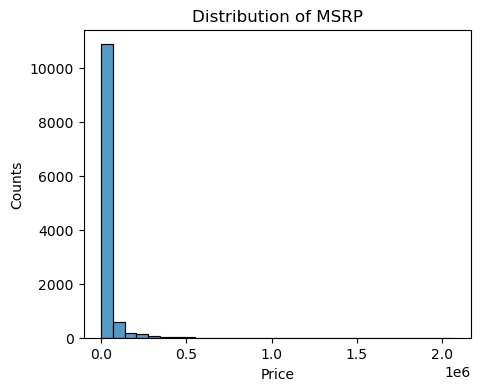

In [356]:
plt.figure(figsize=(5,4))
sns.histplot(data['msrp'], bins=30)
plt.title("Distribution of MSRP")
plt.ylabel("Counts")
plt.xlabel("Price")
plt.show()

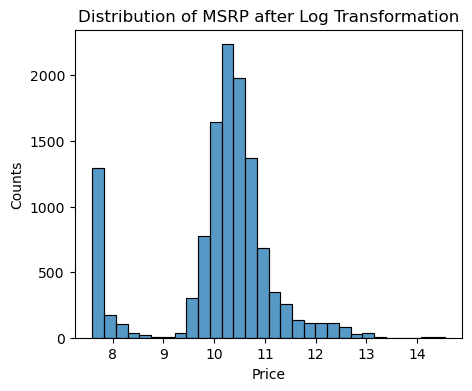

In [357]:
plt.figure(figsize=(5,4))
sns.histplot(np.log1p(data['msrp']), bins=30)
plt.title("Distribution of MSRP after Log Transformation")
plt.ylabel("Counts")
plt.xlabel("Price")
plt.show()

The distribution of the target variable has a long tail, this is due to the extrem values in the dataset, for example the price of bugatti, luxury auto bands

In [358]:
# use log(1+x) transformation to reduce the influence of outliers, +1 is important in case of zero values
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [359]:
lin_reg = LinearRegression()
lin_reg.fit(OH_X_train_reduced, y_train)

lin_y_pred = lin_reg.predict(OH_X_test_reduced)

#Evaluation
lin_reg_cv_scores = cross_val_score(lin_reg, OH_X_train_reduced, y_train, scoring='neg_mean_squared_error', cv=10)
lin_reg_rmse_scores = np.sqrt(-lin_reg_cv_scores)

lin_mae = mean_absolute_error(y_test, lin_y_pred)
lin_mse = mean_squared_error(y_test, lin_y_pred)
lin_rmse = np.sqrt(lin_mse)

lin_mae_in = mean_absolute_error(np.expm1(y_test), np.expm1(lin_y_pred))
lin_mse_in = mean_squared_error(np.expm1(y_test), np.expm1(lin_y_pred))
lin_rmse_in = np.sqrt(lin_mse_in)

print(f"Linear Regression Root Mean squared CV Scores: {lin_reg_rmse_scores.mean()}")
print(f'Linear Regression Mean absolute error: {lin_mae:.2f}')
print(f'Linear Regression Mean squared error: {lin_mse:.2f}')
print(f'Linear Regression Root mean squared error: {lin_rmse:.2f}')
print(f'Linear Regression R-squred score on train data: {lin_reg.score(OH_X_train_reduced, y_train):.2f}')
print(f'Linear Regression R-squred score on test data: {lin_reg.score(OH_X_test_reduced, y_test):.2f}')
print('---------------------------------')
print('Inverse y value ')
print(f'Linear Regression Mean absolute error: {lin_mae_in:.2f}')
print(f'Linear Regression Mean squared error: {lin_mse_in:.2f}')
print(f'Linear Regression Root mean squared error: {lin_rmse_in:.2f}')
print(f'Linear Regression R-squred score on train data: {lin_reg.score(OH_X_train_reduced, y_train):.2f}')
print(f'Linear Regression R-squred score on test data: {lin_reg.score(OH_X_test_reduced, y_test):.2f}')

Linear Regression Root Mean squared CV Scores: 0.4136170701926785
Linear Regression Mean absolute error: 0.27
Linear Regression Mean squared error: 0.15
Linear Regression Root mean squared error: 0.38
Linear Regression R-squred score on train data: 0.86
Linear Regression R-squred score on test data: 0.87
---------------------------------
Inverse y value 
Linear Regression Mean absolute error: 10281.69
Linear Regression Mean squared error: 940123631.58
Linear Regression Root mean squared error: 30661.44
Linear Regression R-squred score on train data: 0.86
Linear Regression R-squred score on test data: 0.87


Now if we observe the R-squared error

Before log transformation on the target variable, the linear model can explain 68% of the test data, after log transformation, the linear model can now explain 87% of the test data. The performance of the model has definitely improved. 

But we can still observe that R-squared score of testing data set is slightly better than the training dataset. This indicate underfitting of the model. 

For training the model, we used all the features and computed PCA dimensionality reduction technique. But still there are 137 columns (principal components). The linear regression model might be too simple. 

## Using ensemble tree based model Random forest to improve model performance

In [362]:
rf = RandomForestRegressor()
rf.fit(OH_X_train_reduced, y_train)

rf_y_pred = rf.predict(OH_X_test_reduced)

# Evaluation
# rf_reg_cv_scores = cross_val_score(rf, OH_X_train_reduced, y_train, scoring='neg_mean_squared_error', cv=10)
# rf_reg_rmse_scores = np.sqrt(-rf_reg_cv_scores)

rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)

rf_mae_in = mean_absolute_error(np.expm1(y_test), np.expm1(rf_y_pred))
rf_mse_in = mean_squared_error(np.expm1(y_test), np.expm1(rf_y_pred))
rf_rmse_in = np.sqrt(rf_mse_in)

#print(f"Random Forest Root Mean squared CV Scores: {rf_reg_rmse_scores.mean()}")
print(f'Random Forest Mean absolute error: {rf_mae:.2f}')
print(f'Random Forest Mean squared error: {rf_mse:.2f}')
print(f'Random Forest Root mean squared error: {rf_rmse:.2f}')
print('---------------------------------')
print('Inverse y value ')
print(f'Random Forest Mean absolute error: {rf_mae_in:.2f}')
print(f'Random Forest Mean squared error: {rf_mse_in:.2f}')
print(f'Random Forest Root mean squared error: {rf_rmse_in:.2f}')
print(f'Random Forest R-squred score on train data: {rf.score(OH_X_train_reduced, y_train):.2f}')
print(f'Random Forest R-squred score on test data: {rf.score(OH_X_test_reduced, y_test):.2f}')

Random Forest Mean absolute error: 0.10
Random Forest Mean squared error: 0.04
Random Forest Root mean squared error: 0.20
Random Forest R-squred score on train data: 0.9937681739196337
Random Forest R-squred score on test data: 0.9664004144652353
---------------------------------
Inverse y value 
Random Forest Mean absolute error: 3876.83
Random Forest Mean squared error: 217758674.58
Random Forest Root mean squared error: 14756.65
Random Forest R-squred score on train data: 0.99
Random Forest R-squred score on test data: 0.97


In [365]:
print(f'RF RMSE on training data set: {np.sqrt(mean_squared_error(y_train, rf.predict(OH_X_train_reduced))):.2f}')

RF RMSE on training data set: 0.08


Using ensemble model like random forest, the performance is better than simple linear regression. 

The RMSE of random forest is 14756.65, which is much less than linear regression (30661.44).

Observing the R-squared score, random forest model can explain 97% of the test data. 


But there is still a drawback. This model is not interpretable, because we use the principal components as features to train this model. The original features has transformed into principal components, which is hard to interpret. 

## Use catboost to improve model performance


Catboost is a kind of boosting algorithm, the special feature of catboost is that it can handle categorical features directly without encoding, and it runs faster than XGBoost. 

We can directly convert the categorical data into the Pool() data type of catboost, without encoding them. Due to this we do not have the high cardinality problem and have to reduce the dimensionality of the features

In [386]:
# cb = CatBoostRegressor(n_estimators=200,
#                        loss_function='RMSE',
#                        learning_rate=0.5,
#                        depth=3, task_type='CPU',
#                        random_state=1,
#                        verbose=False)
cb = CatBoostRegressor()

pool_train = Pool(mlb_X_train, np.expm1(y_train), cat_features = obj_cols)

pool_test = Pool(mlb_X_test, cat_features= obj_cols)

cb.fit(pool_train)
cb_y_pred = cb.predict(pool_test)

Learning rate set to 0.057891
0:	learn: 60960.7905354	total: 90.5ms	remaining: 1m 30s
1:	learn: 58713.7023949	total: 193ms	remaining: 1m 36s
2:	learn: 56787.9173045	total: 284ms	remaining: 1m 34s
3:	learn: 54727.1208105	total: 380ms	remaining: 1m 34s
4:	learn: 52763.3245186	total: 474ms	remaining: 1m 34s
5:	learn: 51029.0576520	total: 575ms	remaining: 1m 35s
6:	learn: 49367.7756945	total: 665ms	remaining: 1m 34s
7:	learn: 47746.3340536	total: 760ms	remaining: 1m 34s
8:	learn: 46226.5200881	total: 849ms	remaining: 1m 33s
9:	learn: 44922.8285003	total: 947ms	remaining: 1m 33s
10:	learn: 43607.7118096	total: 1.09s	remaining: 1m 38s
11:	learn: 42288.7644623	total: 1.18s	remaining: 1m 37s
12:	learn: 41122.5328186	total: 1.29s	remaining: 1m 37s
13:	learn: 39990.8178174	total: 1.41s	remaining: 1m 39s
14:	learn: 38870.5380871	total: 1.51s	remaining: 1m 39s
15:	learn: 37831.4383190	total: 1.6s	remaining: 1m 38s
16:	learn: 36841.5679625	total: 1.69s	remaining: 1m 37s
17:	learn: 35925.0253075	tot

146:	learn: 14127.2033745	total: 14.4s	remaining: 1m 23s
147:	learn: 14062.1412425	total: 14.5s	remaining: 1m 23s
148:	learn: 13995.5749426	total: 14.6s	remaining: 1m 23s
149:	learn: 13953.7690699	total: 14.7s	remaining: 1m 23s
150:	learn: 13913.7656775	total: 14.8s	remaining: 1m 23s
151:	learn: 13874.0878412	total: 14.9s	remaining: 1m 23s
152:	learn: 13847.4950298	total: 15s	remaining: 1m 23s
153:	learn: 13799.5244494	total: 15.1s	remaining: 1m 23s
154:	learn: 13762.0008524	total: 15.2s	remaining: 1m 23s
155:	learn: 13722.4256202	total: 15.4s	remaining: 1m 23s
156:	learn: 13658.1941864	total: 15.5s	remaining: 1m 23s
157:	learn: 13611.2575407	total: 15.6s	remaining: 1m 22s
158:	learn: 13540.4402288	total: 15.7s	remaining: 1m 22s
159:	learn: 13504.7974043	total: 15.8s	remaining: 1m 22s
160:	learn: 13469.8877736	total: 15.8s	remaining: 1m 22s
161:	learn: 13405.4507982	total: 15.9s	remaining: 1m 22s
162:	learn: 13331.3346219	total: 16s	remaining: 1m 22s
163:	learn: 13315.4397468	total: 16

291:	learn: 9087.6432984	total: 29.3s	remaining: 1m 10s
292:	learn: 9073.1507264	total: 29.4s	remaining: 1m 10s
293:	learn: 9048.4460652	total: 29.5s	remaining: 1m 10s
294:	learn: 9024.7087580	total: 29.6s	remaining: 1m 10s
295:	learn: 9007.3756268	total: 29.7s	remaining: 1m 10s
296:	learn: 8991.3754642	total: 29.8s	remaining: 1m 10s
297:	learn: 8980.6964711	total: 29.9s	remaining: 1m 10s
298:	learn: 8958.6774090	total: 30s	remaining: 1m 10s
299:	learn: 8948.0473169	total: 30.1s	remaining: 1m 10s
300:	learn: 8933.8148689	total: 30.2s	remaining: 1m 10s
301:	learn: 8915.4253772	total: 30.3s	remaining: 1m 10s
302:	learn: 8893.5379160	total: 30.4s	remaining: 1m 9s
303:	learn: 8872.6008631	total: 30.5s	remaining: 1m 9s
304:	learn: 8833.0157559	total: 30.6s	remaining: 1m 9s
305:	learn: 8805.6181240	total: 30.7s	remaining: 1m 9s
306:	learn: 8772.8369281	total: 30.8s	remaining: 1m 9s
307:	learn: 8754.2164615	total: 30.9s	remaining: 1m 9s
308:	learn: 8733.8547203	total: 31s	remaining: 1m 9s
309

442:	learn: 7064.5876070	total: 44.7s	remaining: 56.2s
443:	learn: 7049.3357862	total: 44.8s	remaining: 56.1s
444:	learn: 7045.2025730	total: 44.9s	remaining: 56s
445:	learn: 7041.1948834	total: 45s	remaining: 55.9s
446:	learn: 7034.9599945	total: 45.1s	remaining: 55.8s
447:	learn: 7019.3005478	total: 45.2s	remaining: 55.7s
448:	learn: 7013.9030885	total: 45.3s	remaining: 55.6s
449:	learn: 7005.2491861	total: 45.4s	remaining: 55.5s
450:	learn: 6994.6080794	total: 45.5s	remaining: 55.3s
451:	learn: 6988.6842136	total: 45.6s	remaining: 55.2s
452:	learn: 6979.8122211	total: 45.6s	remaining: 55.1s
453:	learn: 6973.3423055	total: 45.7s	remaining: 55s
454:	learn: 6963.5820409	total: 45.8s	remaining: 54.9s
455:	learn: 6956.0111137	total: 45.9s	remaining: 54.8s
456:	learn: 6952.5187185	total: 46s	remaining: 54.7s
457:	learn: 6944.8642630	total: 46.1s	remaining: 54.6s
458:	learn: 6920.1369670	total: 46.2s	remaining: 54.5s
459:	learn: 6908.4103542	total: 46.3s	remaining: 54.4s
460:	learn: 6901.9

595:	learn: 5972.7574349	total: 59.7s	remaining: 40.5s
596:	learn: 5970.4518019	total: 59.8s	remaining: 40.4s
597:	learn: 5968.6071640	total: 59.9s	remaining: 40.3s
598:	learn: 5964.4107549	total: 60s	remaining: 40.2s
599:	learn: 5960.8824269	total: 1m	remaining: 40.1s
600:	learn: 5954.6487371	total: 1m	remaining: 40s
601:	learn: 5952.2441290	total: 1m	remaining: 39.9s
602:	learn: 5949.9192196	total: 1m	remaining: 39.8s
603:	learn: 5944.7927085	total: 1m	remaining: 39.7s
604:	learn: 5942.7314518	total: 1m	remaining: 39.5s
605:	learn: 5939.0732100	total: 1m	remaining: 39.5s
606:	learn: 5937.1633790	total: 1m	remaining: 39.3s
607:	learn: 5933.3551929	total: 1m	remaining: 39.2s
608:	learn: 5928.8937809	total: 1m	remaining: 39.1s
609:	learn: 5923.5389631	total: 1m 1s	remaining: 39s
610:	learn: 5916.2369883	total: 1m 1s	remaining: 38.9s
611:	learn: 5907.6161190	total: 1m 1s	remaining: 38.8s
612:	learn: 5905.1021333	total: 1m 1s	remaining: 38.7s
613:	learn: 5898.5129452	total: 1m 1s	remainin

746:	learn: 5355.0032673	total: 1m 14s	remaining: 25.3s
747:	learn: 5353.5185831	total: 1m 14s	remaining: 25.3s
748:	learn: 5349.1134402	total: 1m 15s	remaining: 25.1s
749:	learn: 5347.2875280	total: 1m 15s	remaining: 25.1s
750:	learn: 5343.4122714	total: 1m 15s	remaining: 25s
751:	learn: 5340.7770967	total: 1m 15s	remaining: 24.9s
752:	learn: 5337.8517364	total: 1m 15s	remaining: 24.8s
753:	learn: 5335.8516265	total: 1m 15s	remaining: 24.6s
754:	learn: 5333.9912035	total: 1m 15s	remaining: 24.5s
755:	learn: 5331.0127058	total: 1m 15s	remaining: 24.4s
756:	learn: 5329.5562064	total: 1m 15s	remaining: 24.3s
757:	learn: 5324.9940008	total: 1m 15s	remaining: 24.2s
758:	learn: 5317.1999433	total: 1m 16s	remaining: 24.1s
759:	learn: 5315.7867887	total: 1m 16s	remaining: 24s
760:	learn: 5314.3702514	total: 1m 16s	remaining: 23.9s
761:	learn: 5310.8077003	total: 1m 16s	remaining: 23.8s
762:	learn: 5309.1809736	total: 1m 16s	remaining: 23.7s
763:	learn: 5306.5292030	total: 1m 16s	remaining: 23

893:	learn: 4907.3947286	total: 1m 29s	remaining: 10.6s
894:	learn: 4904.3387703	total: 1m 29s	remaining: 10.5s
895:	learn: 4903.3614623	total: 1m 29s	remaining: 10.4s
896:	learn: 4901.1498050	total: 1m 29s	remaining: 10.3s
897:	learn: 4899.2990439	total: 1m 30s	remaining: 10.2s
898:	learn: 4894.3078899	total: 1m 30s	remaining: 10.1s
899:	learn: 4893.1917230	total: 1m 30s	remaining: 10s
900:	learn: 4892.5573893	total: 1m 30s	remaining: 9.92s
901:	learn: 4890.0068279	total: 1m 30s	remaining: 9.82s
902:	learn: 4889.0005825	total: 1m 30s	remaining: 9.72s
903:	learn: 4881.3440403	total: 1m 30s	remaining: 9.62s
904:	learn: 4879.8330826	total: 1m 30s	remaining: 9.52s
905:	learn: 4878.6692640	total: 1m 30s	remaining: 9.42s
906:	learn: 4877.6757175	total: 1m 30s	remaining: 9.32s
907:	learn: 4873.7810303	total: 1m 31s	remaining: 9.22s
908:	learn: 4871.2190329	total: 1m 31s	remaining: 9.12s
909:	learn: 4865.8186319	total: 1m 31s	remaining: 9.02s
910:	learn: 4860.7737354	total: 1m 31s	remaining: 

In [387]:
cb_mae = mean_absolute_error(np.expm1(y_test), cb_y_pred)
cb_mse = mean_squared_error(np.expm1(y_test), cb_y_pred)
cb_rmse = np.sqrt(cb_mse)

# cb_mae_in = mean_absolute_error(np.expm1(y_test), np.expm1(cb_y_pred))
# cb_mse_in = mean_squared_error(np.expm1(y_test), np.expm1(cb_y_pred))
# cb_rmse_in = np.sqrt(cb_mse_in)

#print(f"Random Forest Root Mean squared CV Scores: {rf_reg_rmse_scores.mean()}")
print(f'Cat Boost Mean absolute error: {cb_mae:.2f}')
print(f'Cat Boost Mean squared error: {cb_mse:.2f}')
print(f'Cat Boost Root mean squared error: {cb_rmse:.2f}')

# print('---------------------------------')
# print('Inverse y value ')
# print(f'Cat Boost Mean absolute error: {cb_mae_in:.2f}')
# print(f'Cat Boost Mean squared error: {cb_mse_in:.2f}')
# print(f'Cat Boost Root mean squared error: {cb_rmse_in:.2f}')
print(f'Cat Boost R-squred score on train data: {r2_score(np.expm1(y_train), cb.predict(pool_train)):.2f}')
print(f'Cat Boost R-squred score on test data: {r2_score(np.expm1(y_test), cb_y_pred):.2f}')

Cat Boost Mean absolute error: 3595.37
Cat Boost Mean squared error: 95135839.38
Cat Boost Root mean squared error: 9753.76
Cat Boost R-squred score on train data: 0.98
Cat Boost R-squred score on test data: 0.97


Using catboost, the RMSE is 9753.76, which is much smaller than random forest. According to the R-squared value, the catboost model can explain 97% of the test data. And also, this model is interpretable. 

## Use SHAP for more explainability

In [401]:
# Randomly sample a data sample from dataframe
X_sampled = mlb_X_test.sample(10, random_state=42)

In [402]:
# Explain the model's predictions using SHAP values
shap.initjs()
explainer = shap.TreeExplainer(cb)

shap_values = explainer.shap_values(X_sampled)

In [404]:
# Visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0, :], X_sampled.iloc[0, :])

Interpretation:

The base value represents that the value would be predicted if we did not know any features for the current output. The graph shows features each contributing to push the model output from the base value to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. 

The biggest impact comes from engine_hp=180. The year = 2017 pushes the output value higher, but there are more features pushing the output to the model output value. 


In [406]:
np.unique(X_train['market_category'].sum())

array(['crossover', 'diesel', 'exotic', 'factory_tuner', 'flex_fuel',
       'hatchback', 'high-performance', 'hybrid', 'luxury', 'missing',
       'performance'], dtype='<U16')

## Feature Importance

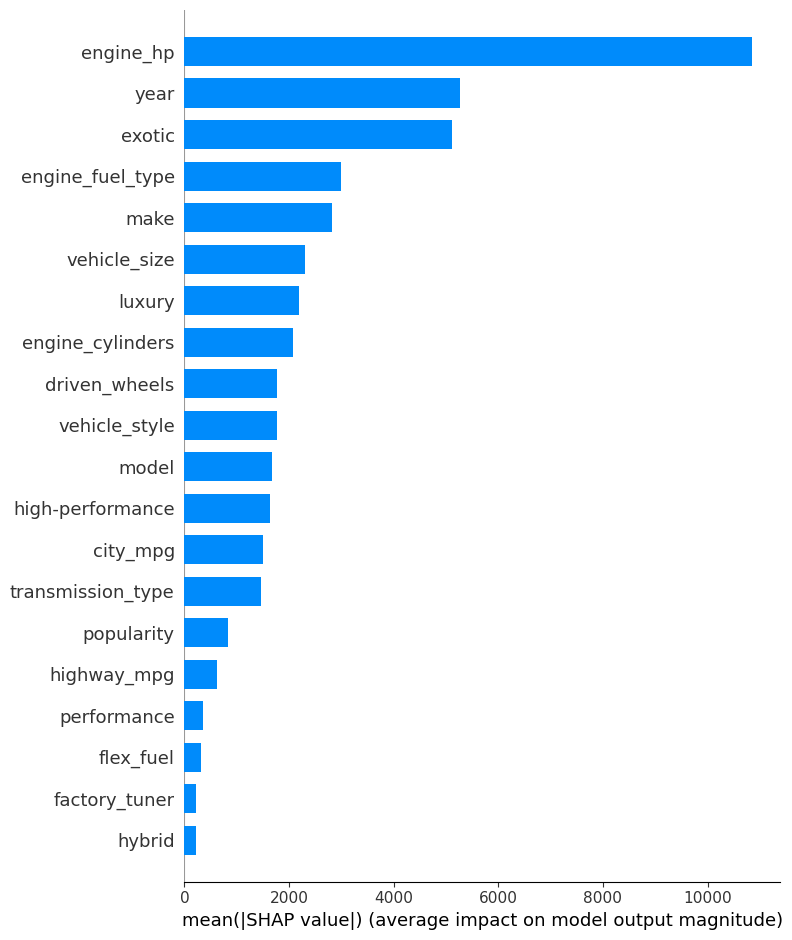

In [405]:
shap_values = explainer.shap_values(mlb_X_test)
shap.summary_plot(shap_values, mlb_X_test, plot_type='bar')

### Save the model

In [408]:
modelname = 'catboost_regression.pickle'
pickle.dump(cb, open(modelname, 'wb'))

# load model
#loaded_model = pickle.load(open(modelname, 'rb'))

## Model deployment

Models can be deployed as service using cloud solutions like Microsoft Azure or Amazon Sagemaker. 

For a fast deployment we can choose Heroku uing Flask. Heroku is a Platform-as-a-Service tool, which acts as a middle-man to provide a scalable, automated rapid deployment platform with all cloud capabilities. 
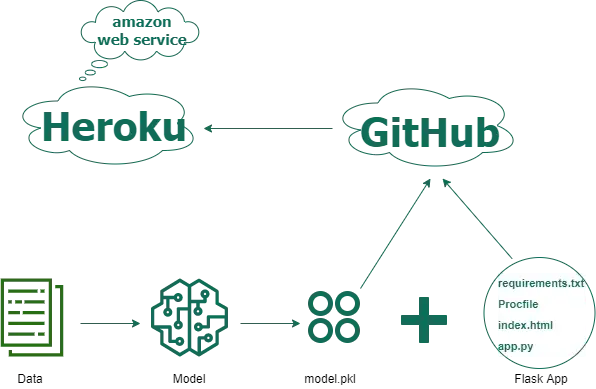

Steps:
1. Create ML Model and save (pickle) it
2. Create Flask files for UI and python main file (app.py) that can unpickle the machine learning model from step 1 and do predictions
3. Create requirements.txt to setup Flask web app with all python dependencies
4. Create Procfile to initiate Flask app command
5. Commit files from Step 1, 2, 3 & 4 in the Github repo
6. Create account/Login on Heroku, create an app, connect with Github repo, and select branch
7. Select manual deploy (or enable Automatic deploys) on Heroku

In [413]:
len(list(mlb_X_train.columns))

25

In [410]:
for col in data[obj_cols]:
    unique_values = data[col].unique()
    print(col)
    print(unique_values)
    print(f"The number of unique values are: {data[col].nunique()}")
    print('--------------------------')

make
['bmw' 'audi' 'fiat' 'mercedes-benz' 'chrysler' 'nissan' 'volvo' 'mazda'
 'mitsubishi' 'ferrari' 'alfa_romeo' 'toyota' 'mclaren' 'maybach'
 'pontiac' 'porsche' 'saab' 'gmc' 'hyundai' 'plymouth' 'honda'
 'oldsmobile' 'suzuki' 'ford' 'cadillac' 'kia' 'bentley' 'chevrolet'
 'dodge' 'lamborghini' 'lincoln' 'subaru' 'volkswagen' 'spyker' 'buick'
 'acura' 'rolls-royce' 'maserati' 'lexus' 'aston_martin' 'land_rover'
 'lotus' 'infiniti' 'scion' 'genesis' 'hummer' 'tesla' 'bugatti']
The number of unique values are: 48
--------------------------
model
['1_series_m' '1_series' '100' '124_spider' '190-class' '2_series' '200'
 '200sx' '240sx' '240' '2' '3_series_gran_turismo' '3_series' '300-class'
 '3000gt' '300' '300m' '300zx' '323' '350-class' '350z' '360' '370z' '3'
 '4_series_gran_coupe' '4_series' '400-class' '420-class' '456m'
 '458_italia' '4c' '4runner' '5_series_gran_turismo' '5_series'
 '500-class' '500e' '500' '500l' '500x' '550' '560-class' '570s' '575m'
 '57' '599' '5' '6_series_